In [1]:
import numpy as np

from emukit.test_functions.multi_fidelity import multi_fidelity_branin_function
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import LatinDesign

from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from collections import namedtuple

Function = namedtuple('Function', ['name', 'y_scale', 'noise_level', 'do_x_scaling', 'num_data', 'fcn'])

branin = Function(name='branin', y_scale=1, noise_level=[0., 0., 0.], do_x_scaling=True, num_data=[80, 30, 10], 
                    fcn=multi_fidelity_branin_function)

In [3]:
def generate_data(fcn_tuple, n_test_points):
    """
    Generates train and test data for
    """
    
    # A different definition of the parameter space for the branin function was used in the paper
    if fcn_tuple.name == 'branin':
        fcn, space = fcn_tuple.fcn()
        new_space = ParameterSpace([ContinuousParameter('x1', -5., 0.), ContinuousParameter('x2', 10., 15.)])
    else:
        fcn, space = fcn_tuple.fcn()
        new_space = ParameterSpace(space._parameters[:-1])
    
    do_x_scaling = fcn_tuple.do_x_scaling
    
    
    # Generate training data
    
    latin = LatinDesign(new_space)
    X = [latin.get_samples(n) for n in fcn_tuple.num_data]
    
    # Scale X if required
    if do_x_scaling:
        scalings = X[0].std(axis=0)
    else:
        scalings = np.ones(X[0].shape[1])
        
    for x in X:
        x /= scalings
    
    Y = []
    for i, x in enumerate(X):
        Y.append(fcn.f[i](x * scalings))
    
    y_scale = fcn_tuple.y_scale
    
    # scale y and add noise if required
    noise_levels = fcn_tuple.noise_level
    if any([n > 0 for n in noise_levels]):
        for y, std_noise in zip(Y, noise_levels):
            y /= y_scale + std_noise * np.random.randn(y.shape[0], 1)
    
    # Generate test data
    x_test = latin.get_samples(n_test_points)
    x_test /= scalings
    y_test = fcn.f[-1](x_test * scalings)
    y_test /= y_scale

    i_highest_fidelity = (len(fcn_tuple.num_data) - 1) * np.ones((x_test.shape[0], 1))
    x_test = np.concatenate([x_test, i_highest_fidelity], axis=1)
    print(X[1].shape)
    return x_test, y_test, X, Y

In [4]:
def calculate_metrics(y_test, y_mean_prediction, y_var_prediction):
    # R2
    r2 = r2_score(y_test, y_mean_prediction)
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_mean_prediction))
    # Test log likelihood
    mnll = -np.sum(scipy.stats.norm.logpdf(y_test, loc=y_mean_prediction, scale=np.sqrt(y_var_prediction)))/len(y_test)
    return {'r2': r2, 'rmse': rmse, 'mnll': mnll}

In [5]:
np.random.seed(123)

x_test, y_test, X, Y = generate_data(branin, 1000)

(30, 2)


In [6]:
X[0].shape, Y[0].shape

((80, 2), (80, 1))

In [7]:
X[1].shape, Y[1].shape

((30, 2), (30, 1))

In [8]:
X[2].shape, Y[2].shape

((10, 2), (10, 1))

In [9]:
x_test.shape, y_test.shape

((1000, 3), (1000, 1))

## To set up the data in three-layer structure
### Cheap data, expensive data, high data

In [10]:
X_branin_cheap = X[0]
X_branin_expensive = X[1]
X_branin_high = X[2]

y_branin_cheap = Y[0]
y_branin_expensive = Y[1]
y_branin_high = Y[2]

import GPy
#from GPy.kern import Kern
#from GPy import Param, Model

m2 = GPy.models.GPRegression(X_branin_expensive, y_branin_expensive)
m2.optimize()

In [11]:
m2.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -49.26715284777377
Optimization restart 2/10, f = -49.267152847772394
Optimization restart 3/10, f = -49.267152847777766
Optimization restart 4/10, f = -49.267152847783194
Optimization restart 5/10, f = -49.26715284777086
Optimization restart 6/10, f = -49.26715284770937
Optimization restart 7/10, f = -49.267152847780906
Optimization restart 8/10, f = -49.26715284778507
Optimization restart 9/10, f = -49.26715284778243
Optimization restart 10/10, f = -49.26715284776553


 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fd0f1ec1f10>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7fd0f1b6e050>]}

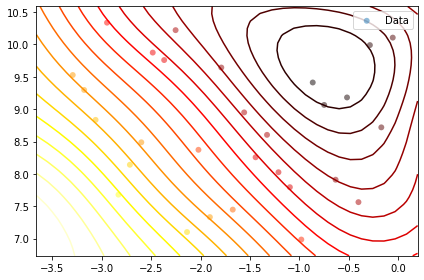

In [12]:
m2.plot()

In [13]:
print(m2)


Name : GP regression
Objective : -49.26715284778507
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |     0.18720563097918025  |      +ve      |        
  rbf.lengthscale          |      1.3422940957082954  |      +ve      |        
  Gaussian_noise.variance  |  2.4377965968668278e-05  |      +ve      |        


## Final stage: prediction the high-level 

In [14]:
X_test = x_test[:,0:2]
X_test.shape
#Y_test=[]
#Y_test_std = []
#Y_test_up=[]
#Y_test_down=[]

#for i in range(X_test.shape[0]):
#    xx = X_test[i].reshape(1,2)
#    Xnew = np.vstack((xx,X_currin_expensive))
#    mu1, v1 = m4.predict(Xnew, full_cov = True)
#    kernMF = MFRBF(input_dim=2,variance = s2, lengthscale = l2, mu = mu1, v=v1)
#    kernRBF = GPy.kern.RBF(input_dim = 2, variance = s1, lengthscale = l1)
#    M1 = kernMF.K(Xnew)
#    M2 = kernRBF.K(Xnew)
#    GG = np.multiply(M1, M2)
    
#    pred_mu, pred_std = predict_eff(GG, y_currin_expensive)
    
#    Y_test.append(pred_mu)
#    Y_test_std.append(pred_std)
#    Y_test_up.append(pred_mu+1.96*pred_std)
#    Y_test_down.append(pred_mu-1.96*pred_std)

(1000, 2)

In [15]:
mu12_3, var12_3 = m2.predict(X_test)

In [17]:
import scipy

print(calculate_metrics(y_test, mu12_3, var12_3))

{'r2': -18.7475263368566, 'rmse': 0.9131173193678647, 'mnll': 5180.8750488538835}


In [18]:
var12_3.shape

(1000, 1)

In [19]:
mu12_3.shape

(1000, 1)

In [20]:
y_test.shape

(1000, 1)

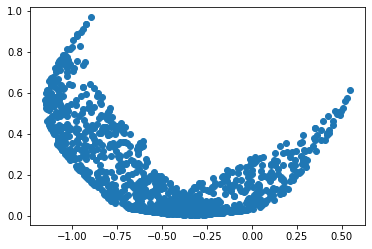

In [26]:
import matplotlib.pyplot as plt

plt.scatter(mu12_3,y_test)
#plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.show()